In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astrosme
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Introduction

This is a demonstration of the **AstroSME** dust modelling feature. This notebook attempts to simulate propagation of starlight from source to telescope through interstellar medium. It is assumed that the density of dust and the intensity and direction of the galactic magnetic field are known at every point between the star and the telescope. The final result is the observed polarization fraction and angle, assuming that the emitted starlight is completely unpolarized.

The physical process is believed to operate as follows: dust grains that lack spherical symmetry tend to align themselves with the galactic magnetic field. Once the grains are aligned, they will preferentially absorb starlight with given linear polarizations, inducing an overall polarization that may be observed at the telescope. The exact reason why asymmetric grains are sensitive to the magnetic field is subject to some debate. An overview of various alignment mechanisms can be found in [Lazarian 1998](https://ui.adsabs.harvard.edu/abs/1999ASPC..168..189L). Here, we stick to the idea of the so-called "paramagnetic absorption", where rotating dust grains "see" the external magnetic field continuously change its direction and induce time-varying magnetization inside the grain. This results in energy dissipation that the grain will minimize by aligning its axis of maximum inertia with the field. The aforementioned rotation of the grains is induced by random collisions with interstellar gas particles (mostly hydrogen atoms). Note that the same collisions will break the alignment as well and, depending on their frequency, the final equilibrium alignment may not be perfect. While **AstroSME** provides some basic treatment of partial alignments, it will not be demonstrated here and a perfect alignment will be assumed.

In our approach, we closely follow the work by [Davis and Greenstein in 1951](https://ui.adsabs.harvard.edu/abs/1951ApJ...114..206D/abstract), which we will subsequently refer to as DG51.

The following important assumptions are made in the process:

1. All dust grains are much smaller than the wavelength of starlight. For the Milky Way, the most dominant grain size is believed to fall around $300$ nm, which is slightly smaller than visible light and much smaller than near infrared. Unfortunately, dust grains of larger sizes are also known to exist.
2. All dust grains are spheroids, parametrized by their aspect ratio that is fixed to a constant value for each simulation.
3. All dust grains are dielectric and have a fixed index of refraction. Physically, this means that they only scatter and do not absorb radiation. Note that a basic treatment of metallic grains is covered in DG51 under the assumption that their refractive index is fully or almost fully imaginary. In principle, we could add it here.
4. The magnetic field is strong enough to fully align all grains everywhere with no precession. Alternatively, collisions with gas molecules are not frequent enough to affect the alignment significantly.
5. Stars carry no intrinsic polarization (i.e. $Q$=$U$=$0$ at emission). It is however easy to extend this code to cover intrinsic polarizations if those are known. See the addendum.
6. Neither stars nor the interstellar medium are compatible with circular polarization (i.e. $V=0$ always)
7. Interstellar dust is optically thin along the line of sight, which is an excellent approximation at high galactic latitudes.
8. Dust grains are reasonably paramagnetic, which also seems to be a good assumption.

## Initialization

We start by instantiating a new `astrosme.Dust()` object and providing it with a data cube, containing the dust grain number density ($n$) and the galactic magnetic field ($B$) at all points on the cube.

For demonstration purposes, we will consider a data cube of $200\times 200 \times 200$ parsecs across with two spherical dust clouds. We will place the star of interest and the observer so that starlight traverses both clouds.

In [2]:
telescope = [-90, -90, -90]    # Place the observer at those coordinates in pc
source    = [90, 90, 90]       # Place the star at those coordinates in pc
north     = [0, 0, 1]          # Direction vector towards celestial North in 3D Cartesian coordinates

# Define grain density and magnetic field data cubes. For now, set them to 0 everywhere (no field, no dust)
# We will be working with a cube of 10x10x10 voxels
B_x = np.full([10, 10, 10], 0.0)
B_y = np.full([10, 10, 10], 0.0)
B_z = np.full([10, 10, 10], 0.0)
n = np.full([10, 10, 10], 0.0)

# We also need to define the axes of the cube
x_axis = np.linspace(-100, 100, 10)  # Each axis runs from -100 pc to 100 pc in 10 steps
y_axis = np.linspace(-100, 100, 10)
z_axis = np.linspace(-100, 100, 10)

# For our convenience, we will also create data cubes for x, y and z coordinates. astrosme.Dust() does not need
# need this
x_m, y_m, z_m = np.meshgrid(x_axis, y_axis, z_axis, indexing = 'ij')

# Let the two clouds lie at (-50, -50, -50) and (50, 50, 50) parsecs. Again, for convenience, let's define two
# more data cubes, storing the distances at every point to the centres of those clouds
r1 = np.sqrt((x_m + 50) ** 2.0 + (y_m + 50) ** 2.0 + (z_m + 50) ** 2.0)
r2 = np.sqrt((x_m - 50) ** 2.0 + (y_m - 50) ** 2.0 + (z_m - 50) ** 2.0)


# Increase the density of grains to 2.25e-7 cm^-2 inside the clouds. Let each cloud be 30 pc in radius
n[r1 <= 30] = 2.25e-7
n[r2 <= 30] = 2.25e-7

# Turn the magnetic field on inside the clouds. Let the field be pointing in the x-direction in one of the
# clouds and in the z-direction in the other
B_x[r1 <= 30] = 1
B_z[r2 <= 30] = 1

my_dust = astrosme.Dust(x_axis, y_axis, z_axis, B_x, B_y, B_z, n, telescope, source, flux_error = 0.01, north = north)

`astrosme.Dust()` implements a few rudimentary routines for plotting the scenario at hand. First, we will use `quiver()` to plot a 3D representation of the data cube.

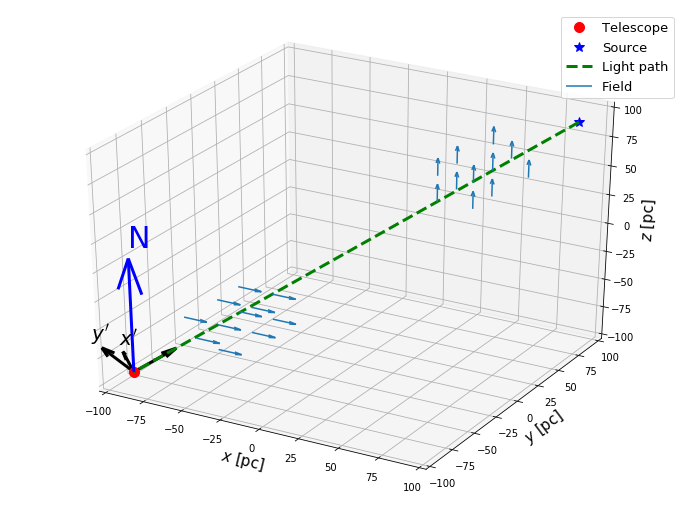

In [3]:
quiver = my_dust.quiver()

# The rest is just plotting
fig = plt.figure(figsize = [12, 9])
ax = fig.gca(projection = '3d')
ax.quiver(*quiver, length = 15, normalize = True, label = 'Field')
ax.plot(*np.reshape(my_dust.telescope, [3, 1]), 'ro', ms = 10, label = 'Telescope')
ax.plot(*np.reshape(my_dust.source, [3, 1]), 'b*', ms = 10, label = 'Source')
ax.plot(*np.array([my_dust.source, my_dust.telescope]).T, 'g--', lw = 3, label = 'Light path')
ax.legend(fontsize = 13)
ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)
ax.set_xlabel('$x$ [pc]', fontsize = 15)
ax.set_ylabel('$y$ [pc]', fontsize = 15)
ax.set_zlabel('$z$ [pc]', fontsize = 15)

# Dust().e1 and Dust().e2 store the unit-vectors of the celestial coordinates of the observer
# Let's plot them too for completeness
ax.quiver(*np.reshape(my_dust.telescope, [3, 1]), *np.reshape(my_dust.e1, [3, 1]), length = 30, color = 'k', lw = 3)
ax.quiver(*np.reshape(my_dust.telescope, [3, 1]), *np.reshape(my_dust.e2, [3, 1]), length = 30, color = 'k', lw = 3)
ax.quiver(*np.reshape(my_dust.telescope, [3, 1]), *np.reshape(my_dust.e3, [3, 1]), length = 30, color = 'k', lw = 3)

# Plot the direction towards North
ax.quiver(*np.reshape(my_dust.telescope, [3, 1]), *np.reshape(north, [3, 1]), length = 100, color = 'b', lw = 3)

ax.text(*(my_dust.telescope + 40 * my_dust.e1), '$x\'$', size = 20)
ax.text(*(my_dust.telescope + 40 * my_dust.e2), '$y\'$', size = 20);
ax.text(*(my_dust.telescope + 110 * np.array(north)), 'N', size = 30, color = 'b');

`quiver()` can equally well produce a view, projected on the celestial plane as seen by the observer.

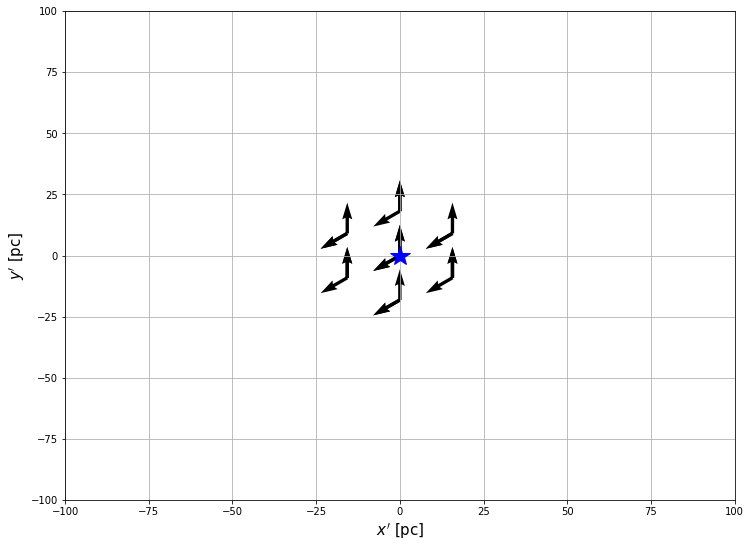

In [4]:
plt.figure(figsize = [12, 9])
quiver = my_dust.quiver(sky = True)
source = my_dust.project([my_dust.e1, my_dust.e2], *my_dust.source)
plt.plot(source[0], source[1], 'b*', ms = 20)
plt.quiver(*quiver, scale = 4e-6, width = 0.005)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.grid()
plt.xlabel('$x\'$ [pc]', fontsize = 15)
plt.ylabel('$y\'$ [pc]', fontsize = 15);

## Scattering cross-section

`Dust().sigma_A()` and `Dust().sigma_T()` give axial and transverse scattering cross-sections for a dust grain of given parameters. For illustration, the cell below plots the ratio of the two for grains of different aspect ratios, $x=a_A/a_T$. It can be clearly seen that for all $x\neq 1$ some polarization effect will be present:

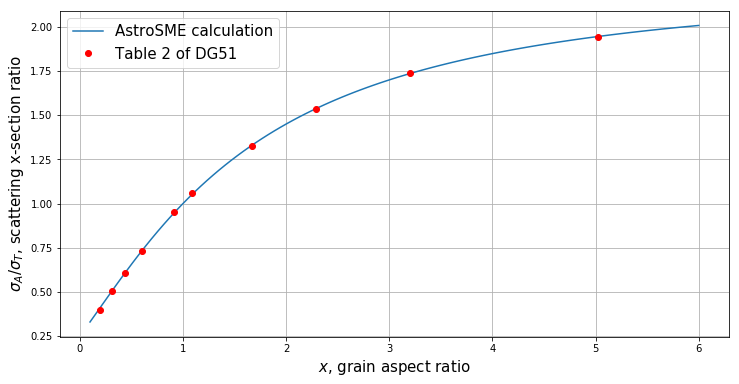

In [5]:
x = np.linspace(0.1, 6, 100)         # Aspect ratios to plot
# Ratio of cross-sections. We set grain radius and wavelength to 1, as they cancel out in the ratio.
# We set the refractive index, m, to sqrt(2) to match the value used by DG51
y = my_dust.sigma_A(1, 1, np.sqrt(2), x) / my_dust.sigma_T(1, 1, np.sqrt(2), x)

plt.figure(figsize = [12, 6])
plt.grid()
plt.plot(x, y, label = 'AstroSME calculation')

# Overplot the values from table 2 of DG51 as a consistency check
x = [0.199, 0.312, 0.436, 0.600, 0.916, 1.091, 1.667, 2.294, 3.203, 5.025]
y = [0.398, 0.505, 0.605, 0.732, 0.952, 1.058, 1.328, 1.538, 1.738, 1.945]
plt.plot(x, y, 'ro', label = 'Table 2 of DG51')

plt.xlabel('$x$, grain aspect ratio', size = 15)
plt.ylabel('$\sigma_A / \sigma_T$, scattering x-section ratio', size = 15)
plt.legend(fontsize = 15);

## Grain size distribution



Since the scattering cross-section is dependent on the size of dust grains, we must assume a realistic grain size distribution to proceed. `Dust().grain_size()` offers some dust distributions from external literature sources to consider. In the cell below, we load the distribution from [Weingartner and Draine, 2001](https://ui.adsabs.harvard.edu/abs/2001ApJ...548..296W/abstract) and plot it right away.

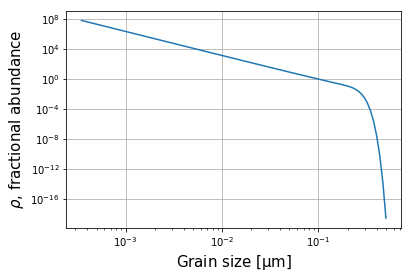

In [6]:
a, rho = my_dust.grain_size('weingartner-draine')

plt.plot(a * 1e4, rho)
plt.xlabel(r'Grain size [$\mathrm{\mu m}$]', size = 15)
plt.ylabel(r'$\rho$, fractional abundance', size = 15)
plt.grid()

plt.xscale('log')
plt.yscale('log')

### Simulation

Now we have everything in place to start propagating photons. In fact, the entire process amounts to a single function call:

In [93]:
wl = 500e-7                     # Photon wavelength in cm
m = np.sqrt(2)                  # Refractive index of dust
x = 1.1                         # Aspect ratio of dust grains
pol, psi = my_dust.receive_photon(wl, m, x, a, rho, F = 0.4, show_progress = 'tqdm_notebook')

print('Observed polarization fraction:', pol)
print('Observed polarization angle (deg):', psi)

A Jupyter Widget


Observed polarization fraction: 0.007760279399686902
Observed polarization angle (deg): 59.99962646801061


In addition to absorbing starlight, dust will also emit radiation of its own at microwave wavelengths. The emission polarization can be calculated following appendix B of [Planck XX](https://arxiv.org/pdf/1405.0872.pdf). Here, the calculation is implemented in `receive_ism_emission()` that can be called almost identically:

In [84]:
e_pol, e_psi = my_dust.receive_ism_emission(x, show_progress = 'tqdm_notebook')

print('Emitted polarization fraction:', e_pol)
print('Emitted polarization angle (deg):', e_psi)

A Jupyter Widget


Emitted polarization fraction: 0.06666666667062113
Emitted polarization angle (deg): -30.000312030551974


Once the polarization characteristics of the arriving photon are known, we can plot the observer's view again. This time, we will also plot the polarization vector for both starlight and emitted light.

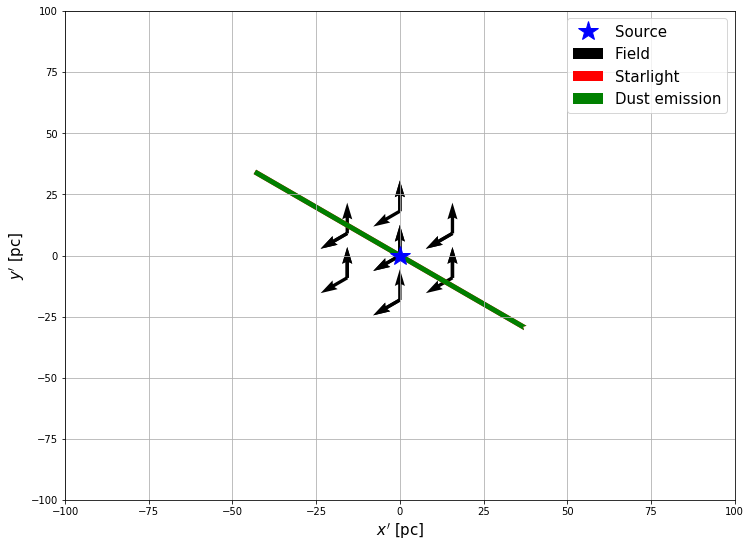

In [85]:
plt.figure(figsize = [12, 9])
quiver = my_dust.quiver(sky = True)
source = my_dust.project([my_dust.e1, my_dust.e2], *my_dust.source)
plt.plot(source[0], source[1], 'b*', ms = 20, label = 'Source')
plt.quiver(*quiver, scale = 4e-6, width = 0.005, label = 'Field')
# Plot the polarization vectors
plt.quiver(0, 0, np.cos(np.radians(psi)), np.sin(np.radians(psi)), scale = 2, color = 'r', headwidth = 0, pivot = 'middle', label = 'Starlight')
plt.quiver(0, 0, np.cos(np.radians(e_psi)), np.sin(np.radians(e_psi)), scale = 2, color = 'g', headwidth = 0, pivot = 'middle', label = 'Dust emission')

plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.grid()
plt.xlabel('$x\'$ [pc]', fontsize = 15)
plt.ylabel('$y\'$ [pc]', fontsize = 15)
plt.legend(fontsize = 15)

For completeness, `Dust().receive_photon()` accepts an optional argument called "`return_all`". When set to `True`, the Stokes parameters ($I$, $Q$ and $U$) will be returned for every point of integration along the light path from the source to the telescope in addition to the total optical depth along the line of sight. The cell below uses this feature to show how the photon gains its polarization as it is travelling through the clouds:

A Jupyter Widget

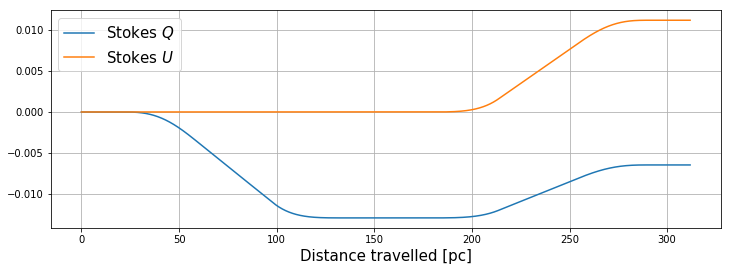

In [12]:
pol, psi, tau, dist, stokes = my_dust.receive_photon(wl, m, x, a, rho, return_all = True, show_progress = 'tqdm_notebook')

plt.figure(figsize = [12, 4])
plt.grid()
plt.xlabel('Distance travelled [pc]', size = 15)
plt.plot(dist, stokes[1] / stokes[0], label = 'Stokes $Q$')
plt.plot(dist, stokes[2] / stokes[0], label = 'Stokes $U$')
plt.legend(fontsize = 15)

## Addendum 1: extinction

`tau` stores the optical depth along the line of sight towards the star. From it, we can calculate the expected extinction and compare it against a known extinction law to ensure that the output of the propagation model is consistent:

In [26]:
# Calculate the extinction predicted by the model in magnitudes
Av = 2.5 * np.log10(np.e) * tau
print('Calculated extinction: {} mag'.format(Av))

# Calculate the column density of dust towards the star
path = (np.linspace(my_dust.telescope[0], my_dust.source[0], 1000),
        np.linspace(my_dust.telescope[1], my_dust.source[1], 1000),
        np.linspace(my_dust.telescope[2], my_dust.source[2], 1000))
dust_volumne_density = my_dust.eval(*path)[4]
dust_column_density = np.trapz(dust_volumne_density, dx = my_dust.distance / 1000 * astrosme.spc.parsec * 1e2)

# Calculate the column density of gas towards the star
gas_column_density = dust_column_density / my_dust.dust_to_gas_ratio(gas_molecular_mass = 1.0)

# Calculate the expected extinction based on the extinction law from 2001ApJ...548..296W
Av = 5.3e-22 * gas_column_density
print('Expected extinction: {} mag'.format(Av))

Calculated extinction: 1.4700133677245768 mag
Expected extinction: 1.1272243405844034 mag


## Addendum 2: Mueller matrices

Previously, it was demonstrated how `receive_photon()` can simulate light propagation through the interstellar medium. The dust along the line of sight effectively acts as a non-trivial optical medium described by some Mueller matrix. **AstroSME** can also be used to compute this matrix, which can then be used to propagate photons of other polarizations along the same line of sight.

To retrieve the Mueller matrix, set `return_mueller` and `return_all` to `True`:

In [27]:
pol, psi, tau, dist, stokes, mueller = my_dust.receive_photon(wl, m, x, a, rho, return_all = True, return_mueller = True, show_progress = 'tqdm_notebook')

print(mueller)

A Jupyter Widget


[[ 2.58207511e-01 -1.66533870e-03  2.88419206e-03]
 [-1.66513091e-03  2.58191400e-01  9.30051349e-06]
 [ 2.88431203e-03 -2.79024382e-05  2.58202140e-01]]


We can now use the matrix to propagate an unpolarized photon...

In [28]:
I,Q,U = mueller * np.matrix([1, 0, 0]).T
print('Polarization:', np.sqrt(Q**2 + U**2) / I)

Polarization: [[0.01289836]]


or a polarized one...

In [29]:
I,Q,U = mueller * np.matrix([1, 0.2, 0.2]).T
print('Polarization:', np.sqrt(Q**2 + U**2) / I)

Polarization: [[0.28615981]]
